## Classification
This document consists of two parts.
- The first part uses logistic models to predict Parkinson's Disease. The data is from UCI Machine Learning Repository (http://archive.ics.uci.edu/ml/index.php). This section also includes modeling improvement techniques that noticeably improves the predicting performance.
- The second part applies k-NN to perform multi-class classification, identifying numbers from pixels. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

## Part I
### Data Preparation

In [2]:
psd = pd.read_csv('C:/Users/byron/Desktop/data/pd_speech_features.csv', header=1)

In [3]:
psd.head()

,id,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,...,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36,class
0,0,1,0.85247,0.71826,0.57227,240,239,0.008064,0.000087,0.00218,...,1.5620,2.6445,3.8686,4.2105,5.1221,4.4625,2.6202,3.0004,18.9405,1
1,0,1,0.76686,0.69481,0.53966,234,233,0.008258,0.000073,0.00195,...,1.5589,3.6107,23.5155,14.1962,11.0261,9.5082,6.5245,6.3431,45.1780,1
2,0,1,0.85083,0.67604,0.58982,232,231,0.008340,0.000060,0.00176,...,1.5643,2.3308,9.4959,10.7458,11.0177,4.8066,2.9199,3.1495,4.7666,1
3,1,0,0.41121,0.79672,0.59257,178,177,0.010858,0.000183,0.00419,...,3.7805,3.5664,5.2558,14.0403,4.2235,4.6857,4.8460,6.2650,4.0603,1
4,1,0,0.32790,0.79782,0.53028,236,235,0.008162,0.002669,0.00535,...,6.1727,5.8416,6.0805,5.7621,7.7817,11.6891,8.2103,5.0559,6.1164,1


In [4]:
psd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Columns: 755 entries, id to class
dtypes: float64(749), int64(6)
memory usage: 4.4 MB


In [5]:
psd['class'].value_counts()

1    564
0    192
Name: class, dtype: int64

In [36]:
X = psd.iloc[:,:-1]
y = psd.iloc[:,-1]

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify=y)

### Fit and predict model

In [8]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
pred = logreg.predict(X_test)
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

          0       0.70      0.21      0.32        77
          1       0.78      0.97      0.87       226

avg / total       0.76      0.78      0.73       303



### ROC Curve & AUC

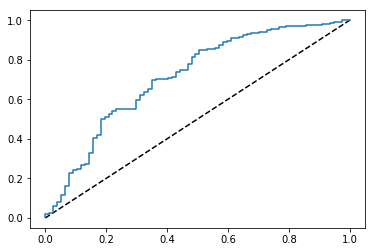

In [9]:
y_pred_prob = logreg.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.show()

In [10]:
roc_auc_score(y_test, y_pred_prob)

0.71233191587173894

In [11]:
# AUC using cross-validation
from sklearn.model_selection import cross_val_score

In [12]:
cv_scores = cross_val_score(logreg, X_train, y_train, cv=5, scoring='roc_auc')
cv_scores

array([ 0.65792839,  0.80306905,  0.73273657,  0.61778066,  0.78780013])

### Model Improvement
The following steps are applied to improve prediction.
- Scaling
- Pipeline
- Grid Search CV
- Hold-out set

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [44]:
steps = [('scaler', StandardScaler()),
        ('LogisticRegression', LogisticRegression())]
pipeline = Pipeline(steps)
c_space = np.logspace(-5, 5, 15)
parameters = {'LogisticRegression__C': c_space}
cv = GridSearchCV(pipeline, param_grid=parameters)

In [45]:
cv.fit(X_train, y_train)
y_pred_2 = cv.predict(X_test)
print(cv.best_params_, cv.best_score_)

{'LogisticRegression__C': 0.037275937203149416} 0.825607064018


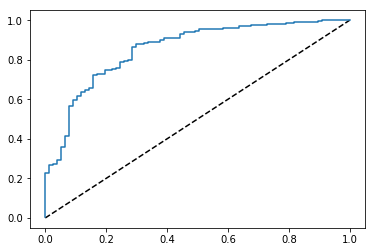

In [46]:
y_pred_prob_2 = cv.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_2)
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.show()

In [47]:
print(classification_report(y_test, y_pred_2))
print('AUC: {}'.format(roc_auc_score(y_test, y_pred_prob_2)))

             precision    recall  f1-score   support

          0       0.64      0.71      0.67        77
          1       0.90      0.86      0.88       226

avg / total       0.83      0.83      0.83       303

AUC: 0.8539248362257212


## Part II
### Data Preparation

In [18]:
# Import data
digits = datasets.load_digits()

In [19]:
digits.keys()

dict_keys(['DESCR', 'target', 'images', 'target_names', 'data'])

In [20]:
#print(digits.DESCR)

In [21]:
digits.images.shape

(1797, 8, 8)

In [22]:
digits.data.shape

(1797, 64)

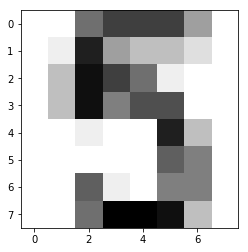

In [23]:
plt.imshow(digits.images[1010], cmap=plt.cm.gray_r, interpolation='nearest')
plt.show()

In [24]:
# Create feature and target arrays
X = digits.data
y = digits.target

# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, stratify=y)

### Inspect overfitting and underfitting

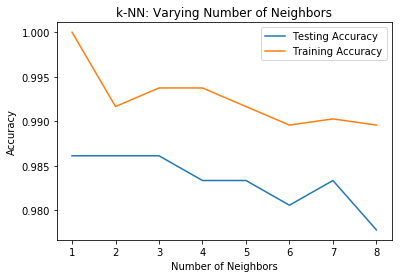

In [25]:
# Setup arrays to store train and test accuracies
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(k)

    # Fit the classifier to the training data
    knn.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train,y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

### Fit and predict model

In [26]:
# Create a k-NN classifier with 7 neighbors: knn
knn = KNeighborsClassifier(7)

# Fit the classifier to the training data
knn.fit(X_train, y_train)

# Get the accuracy
knn.score(X_test, y_test)

0.98333333333333328

In [27]:
y_pred = knn.predict(X_test)

### Performance

In [28]:
confusion_matrix(y_test, y_pred)

array([[36,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 36,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 35,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 37,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 36,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 37,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 35,  0,  1,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 36,  0,  0],
       [ 0,  2,  0,  0,  0,  0,  0,  1, 32,  0],
       [ 0,  0,  0,  0,  1,  0,  0,  0,  1, 34]], dtype=int64)

In [29]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        36
          1       0.95      1.00      0.97        36
          2       1.00      1.00      1.00        35
          3       1.00      1.00      1.00        37
          4       0.97      1.00      0.99        36
          5       1.00      1.00      1.00        37
          6       1.00      0.97      0.99        36
          7       0.97      1.00      0.99        36
          8       0.94      0.91      0.93        35
          9       1.00      0.94      0.97        36

avg / total       0.98      0.98      0.98       360



In [48]:
# To add another index used in school project